<a href="https://colab.research.google.com/github/eyalgur1/Computer_Vision/blob/main/2_Image_Pyramids_and_Frequency_Domains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# LaTeX and Google Drive configuration

!sudo apt-get update
!sudo apt-get install -y texlive texlive-latex-extra dvipng texlive-fonts-recommended cm-super


plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text
    "font.family": "serif",          # Use serif fonts
    "font.serif": ["Computer Modern Roman"],  # Use Computer Modern Roman font
    "text.latex.preamble": r"\usepackage{amsmath}",  # Load additional packages
    "font.size": 16,                 # Default font size
    "axes.titlesize": 16,            # Title font size
    "axes.labelsize": 16,            # Axis labels font size
    "xtick.labelsize": 10,           # X-tick labels font size
    "ytick.labelsize": 10,           # Y-tick labels font size
    "legend.fontsize": 14            # Legend font size
})

from google.colab import drive
drive.mount("/content/drive/")

## **Aliasing and Anti-Aliasing with Gaussian Smoothing**

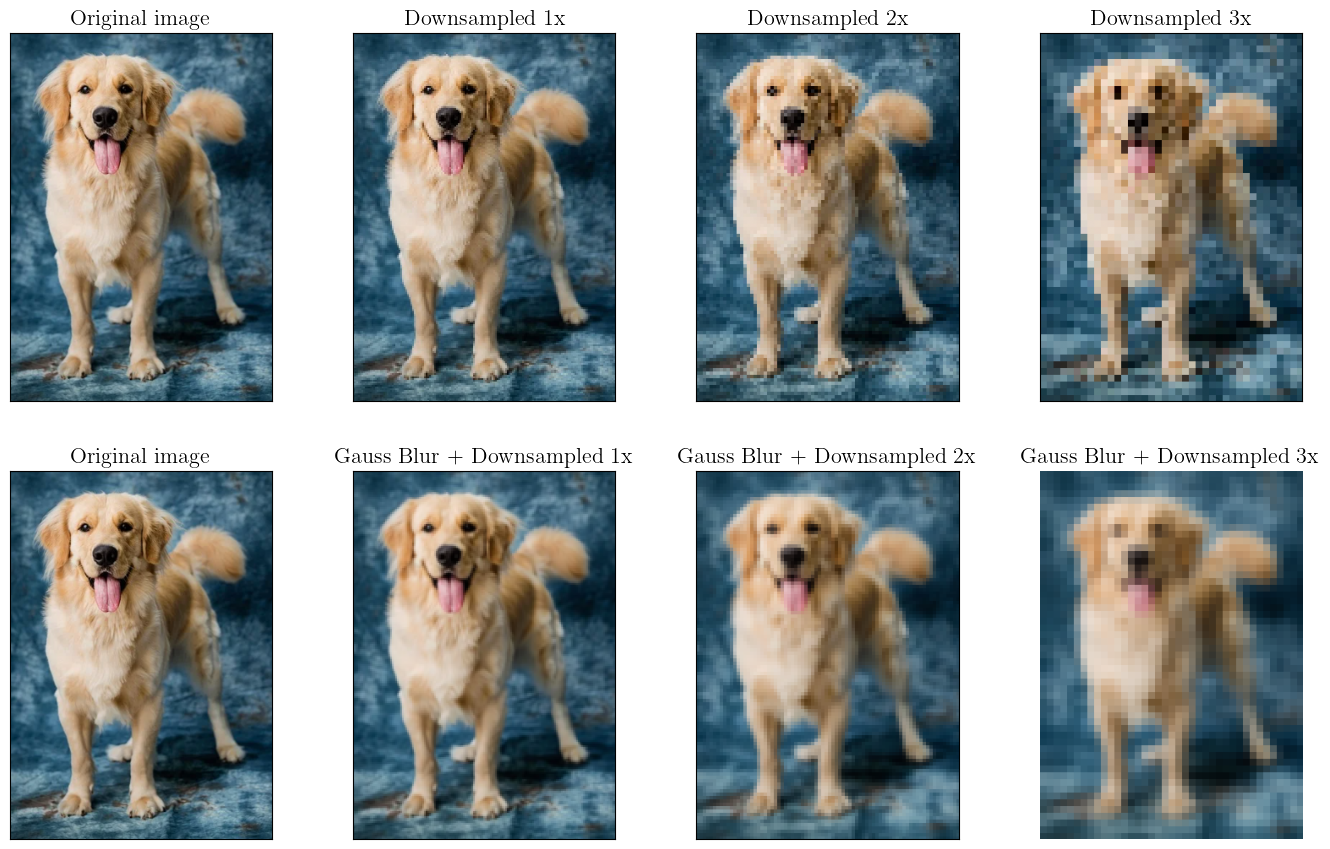

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load an image
image_cv2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/dog.PNG', 1)
image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)/255.0

# Function to downsample an image by removing every other row and column
def downsample(image):
    return image[::2, ::2]

# Function to apply Gaussian blur and then downsample
def gaussian_blur_downsample(image, ksize=5, sigma=1):
    blurred_image = cv2.GaussianBlur(image, (ksize, ksize), sigma)
    return downsample(blurred_image)

# Downsample twice without Gaussian blur
downsampled1 = downsample(image)
downsampled2 = downsample(downsampled1)
downsampled3 = downsample(downsampled2)

# Downsample twice with Gaussian blur
blurred_downsampled1 = gaussian_blur_downsample(image)
blurred_downsampled2 = gaussian_blur_downsample(blurred_downsampled1)
blurred_downsampled3 = gaussian_blur_downsample(blurred_downsampled2)

# Resize images to the original size for display
resized_downsampled1 = cv2.resize(downsampled1, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
resized_downsampled2 = cv2.resize(downsampled2, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
resized_downsampled3 = cv2.resize(downsampled3, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
resized_blurred_downsampled1 = cv2.resize(blurred_downsampled1, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
resized_blurred_downsampled2 = cv2.resize(blurred_downsampled2, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
resized_blurred_downsampled3 = cv2.resize(blurred_downsampled3, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# How `interpolation=cv2.INTER_NEAREST` works:
# When an image is resized (either up or down), the new pixel grid may not align perfectly with the original pixel grid.
# The INTER_NEAREST method assigns the value of the nearest pixel from the original image to the new pixel grid.
# For instance, if we are enlarging an image, each new pixel in the enlarged image takes the value of the closest pixel in the original image.
# If we are reducing the image size, each pixel in the reduced image corresponds directly to the closest pixel in the original image.

# Plot all images
f, ax = plt.subplots(2,4, figsize=(14,9))
ax[0,0].imshow(image); ax[0,0].set_title('Original image'); plt.axis('off')  # display original image
ax[0,1].imshow(resized_downsampled1); ax[0,1].set_title('Downsampled 1x'); plt.axis('off')
ax[0,2].imshow(resized_downsampled2); ax[0,2].set_title('Downsampled 2x'); plt.axis('off')
ax[0,3].imshow(resized_downsampled3); ax[0,3].set_title('Downsampled 3x'); plt.axis('off')
ax[1,0].imshow(image); ax[1,0].set_title('Original image'); plt.axis('off')  # display original image
ax[1,1].imshow(resized_blurred_downsampled1); ax[1,1].set_title('Gauss Blur + Downsampled 1x'); plt.axis('off')
ax[1,2].imshow(resized_blurred_downsampled2); ax[1,2].set_title('Gauss Blur + Downsampled 2x'); plt.axis('off')
ax[1,3].imshow(resized_blurred_downsampled3); ax[1,3].set_title('Gauss Blur + Downsampled 3x'); plt.axis('off')
plt.tight_layout()
# remove xticks and yticks
for i in range (2):
  for j in range (4):
    ax[i,j].set_xticks([]); ax[i,j].set_yticks([])
plt.show()

## **Gaussain and Laplacian Pyramids**

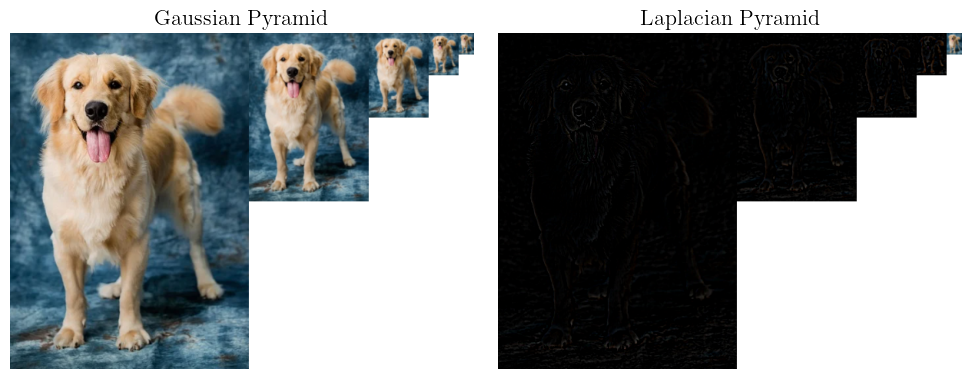

In [5]:
import cv2
from matplotlib import pyplot as plt

# Load an image
image_cv2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/dog.PNG', 1)
image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)/255.0

# Function to generate Gaussian pyramid (there is a built-it cv2 function for this)
def gaussian_pyramid(image, levels=5, ksize=5, sigma=1):
    pyramid = [image]
    for i in range(1, levels):
        # Apply Gaussian blur
        blurred_image = cv2.GaussianBlur(pyramid[-1], (ksize, ksize), sigma)
        # Downsample the image by removing every other row and column
        downsampled_image = blurred_image[::2, ::2, :]  # (we could use cv2.pyrDown for this)
        pyramid.append(downsampled_image)
    return pyramid

# Function to generate Laplace pyramid from Gaussian pyramid (there is a built-it cv2 function for this)
def laplace_pyramid(gaussian_pyramid):
    laplace_pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        # Upsample the next level in the Gaussian pyramid by doubling the number of rows and doubling the number of columns by inserting new pixel every other row/column and using nearest pixel technique to decide the value of the new pixels
        upsampled_image = cv2.pyrUp(gaussian_pyramid[i + 1])
        # Ensure that the upsampled image matches the size of the current level (as for odd or even number of ros/columns there could be up to 1 pixel difference in size due to downsampling/upsampling)
        upsampled_image = cv2.resize(upsampled_image, (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0]))
        # Calculate the Laplacian image
        laplacian = gaussian_pyramid[i] - upsampled_image
        laplace_pyramid.append(laplacian)
    # The last image in the Laplace pyramid is just the last image in the Gaussian pyramid
    laplace_pyramid.append(gaussian_pyramid[-1])
    return laplace_pyramid

# Function to concatenate pyramid images side by side with a white background (for plotting)
def concatenate_pyramid_images(pyramid):
    # Find the maximum height in the pyramid
    max_height = max([img.shape[0] for img in pyramid])

    # Resize each image to have the same height by adding white constant background and using top,bottom,left,right borders
    resized_images = [cv2.copyMakeBorder(img, 0, max_height - img.shape[0], 0, 0, cv2.BORDER_CONSTANT, value=[1, 1, 1]) for img in pyramid]
    return np.concatenate(resized_images, axis=1)  # concatenate the images

# Generate the Gaussian pyramid
gaussian_pyr = gaussian_pyramid(image, levels=5, ksize=5, sigma=1)
# Generate the Laplace pyramid
laplace_pyr = laplace_pyramid(gaussian_pyr)

# Concatenate Gaussian and Laplace pyramid images
concatenated_gaussian = concatenate_pyramid_images(gaussian_pyr)
concatenated_laplace = concatenate_pyramid_images(laplace_pyr)

# Plot the concatenated images
plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
plt.imshow(concatenated_gaussian)
plt.title('Gaussian Pyramid')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(concatenated_laplace)  # multiplied by 3 just for the sake of better visaulization (not for analysis!!)
plt.title('Laplacian Pyramid')
plt.axis('off')

plt.tight_layout()
plt.show()


## **Compression and Reconstruction Using Laplacian Pyramid**

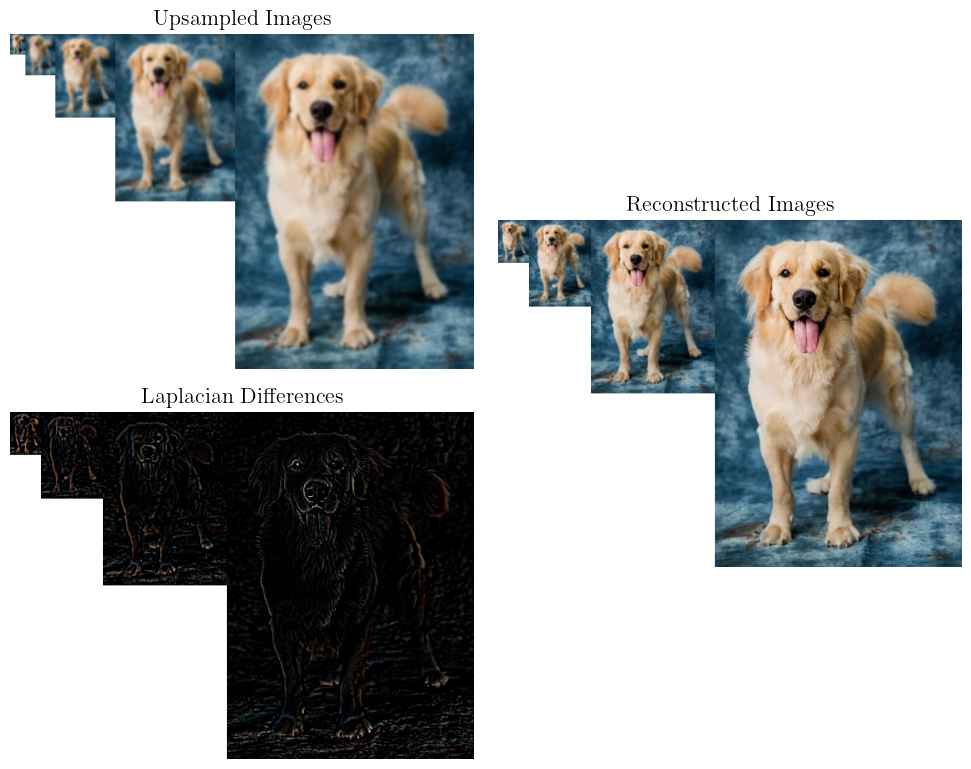

In [6]:
import matplotlib.gridspec as gridspec

# Load an image
image_cv2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/dog.PNG', 1)
image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)/255.0

# Generate the Gaussian pyramid
gaussian_pyr = gaussian_pyramid(image, levels=5, ksize=5, sigma=1)
# Generate the Laplace pyramid
laplace_pyr = laplace_pyramid(gaussian_pyr)

# concatenate images side by side with a white background (for plotting)
def concatenate_images(images):
    max_height = max(img.shape[0] for img in images)
    total_width = sum(img.shape[1] for img in images)
    concatenated_image = np.ones((max_height, total_width, 3))  # White background

    current_x = 0
    for img in images:
        height, width = img.shape[:2]
        concatenated_image[:height, current_x:current_x + width] = img
        current_x += width

    return concatenated_image

# Reconstruction process with visualization
reconstructed_images = []
upsampled_images = []
reconstructed_image = laplace_pyr[-1]  # starting point of reconstrcution proces
upsampled_images.append(reconstructed_image)

for i in range(len(laplace_pyr) - 1, 0, -1): # start from the last image (the smallest one) and go back until the largest one
    upsampled_image = cv2.pyrUp(reconstructed_image)  # upsample
    upsampled_image = cv2.resize(upsampled_image, (laplace_pyr[i-1].shape[1], laplace_pyr[i-1].shape[0]))  # verify proper dimension for addition due to up to one pixel change because on upsampling/dowsampling
    upsampled_images.append(upsampled_image)
    reconstructed_image = upsampled_image + laplace_pyr[i-1]
    reconstructed_images.append(reconstructed_image)

# Concatenate all reconstructed images
concatenated_reconstructed = concatenate_images(reconstructed_images[::1])  # Reverse to start with the smallest image
# Concatenate all upsampled images
concatenated_upsampled = concatenate_images(upsampled_images[::1])  # Reverse to start with the smallest image
# Concatenate all Laplacian differences
concatenated_laplacian = concatenate_images(laplace_pyr[:-1][::-1])  # Reverse and exclude the smallest image as we only plot differences

# Plot the final concatenated images
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(concatenated_upsampled)
ax1.set_title('Upsampled Images')
ax1.axis('off')

ax2 = fig.add_subplot(gs[1, 0])
ax2.imshow(concatenated_laplacian*3)  # multiplied by 3 just for the sake of better visaulization (not for analysis!!)
ax2.set_title('Laplacian Differences')
ax2.axis('off')

ax3 = fig.add_subplot(gs[:, 1])
ax3.imshow(concatenated_reconstructed)
ax3.set_title('Reconstructed Images')
ax3.axis('off')

plt.tight_layout()
plt.show()

## **Image Blending**

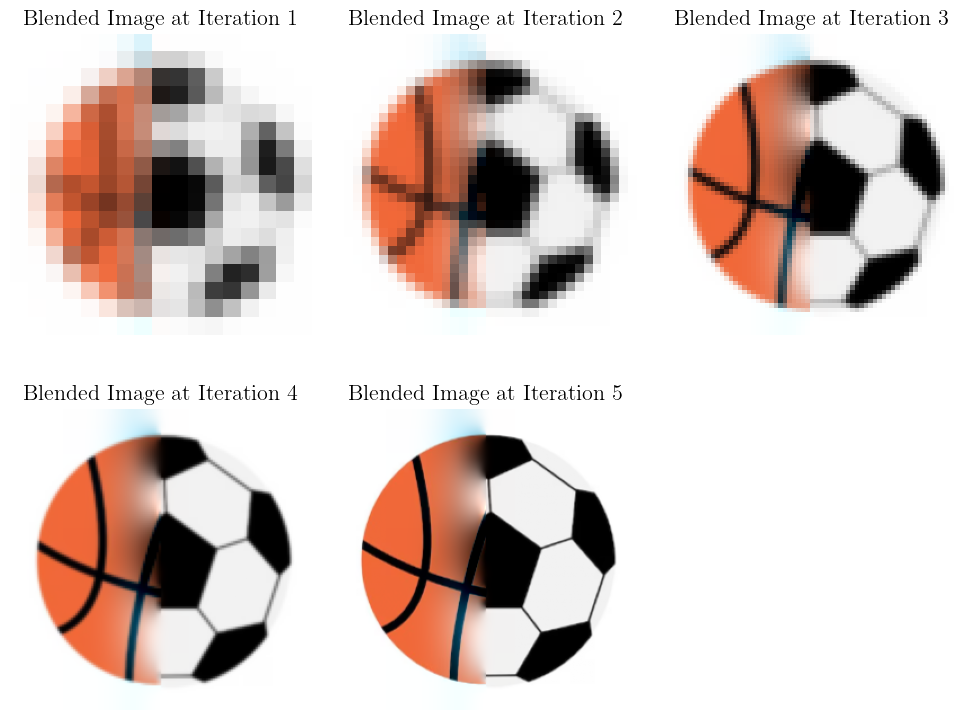

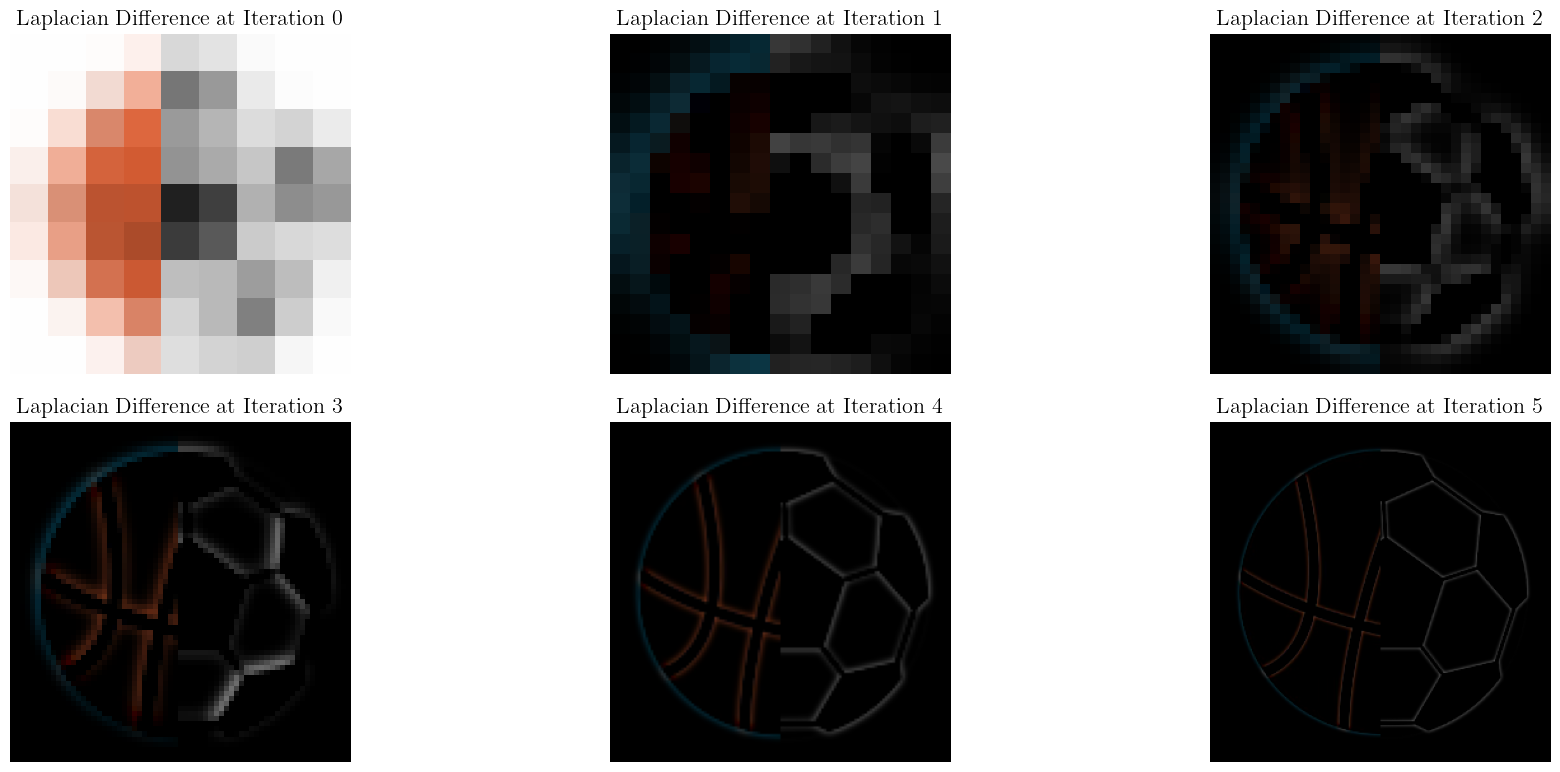

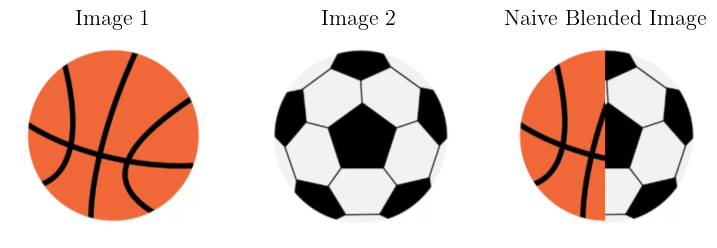

In [7]:
# Function to blend two Laplacian pyramids and reconstruct the image
def blend_pyramids(lap_pyr1, lap_pyr2):
    # takes two Laplacian pyramids as input
    blended_pyramid = []

    # Concatenate corresponding layers from the two pyramids
    for l1, l2 in zip(lap_pyr1, lap_pyr2):
        rows, cols, dpt = l1.shape
        blended_layer = np.hstack((l1[:, :cols // 2], l2[:, cols // 2:]))
        blended_pyramid.append(blended_layer)

    # Reconstruct the blended image
    reconstructed_image = blended_pyramid[-1]
    plt.figure(figsize=(10, 8))
    for i in range(len(blended_pyramid) - 2, -1, -1):
        reconstructed_image = cv2.pyrUp(reconstructed_image)  # upsample
        reconstructed_image = cv2.resize(reconstructed_image, (blended_pyramid[i].shape[1], blended_pyramid[i].shape[0]))  # same note as earlier codes
        reconstructed_image = reconstructed_image + blended_pyramid[i]

        # Display the current blended image
        plt.subplot(2, len(blended_pyramid)//2, len(blended_pyramid) - i - 1)
        plt.imshow(reconstructed_image)
        plt.title(f'Blended Image at Iteration {len(blended_pyramid) - i - 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return reconstructed_image, blended_pyramid

# Load two images
image_cv2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_basket.png', 1)
image1 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)/255.0
image_cv2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 1)
image2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)/255.0


# Ensure the images are the same size
image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

# Generate Gaussian and Laplacian pyramids for both images (use even number of levels)
levels = 6
gaussian_pyr1 = gaussian_pyramid(image1, levels=levels)
gaussian_pyr2 = gaussian_pyramid(image2, levels=levels)
laplace_pyr1 = laplace_pyramid(gaussian_pyr1)
laplace_pyr2 = laplace_pyramid(gaussian_pyr2)

# Blend the Laplacian pyramids and reconstruct the final blended image
blended_image, blended_pyramid = blend_pyramids(laplace_pyr1, laplace_pyr2)

plt.figure(figsize=(20, 8))
for i in range(len(blended_pyramid) - 1, -1, -1):
    plt.subplot(2, len(blended_pyramid)//2, len(blended_pyramid) - i)
    plt.imshow(blended_pyramid[i])
    plt.title(f'Laplacian Difference at Iteration {len(blended_pyramid) - i - 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

naive_blended_layer = np.hstack((image1[:, :image1.shape[1] // 2], image2[:, image1.shape[1] // 2:]))
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Image 1')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(image2)
plt.title('Image 2')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(naive_blended_layer)
plt.title('Naive Blended Image')
plt.axis('off')
plt.show()

## **Fourier Series - Periodic Square Wave Signal**

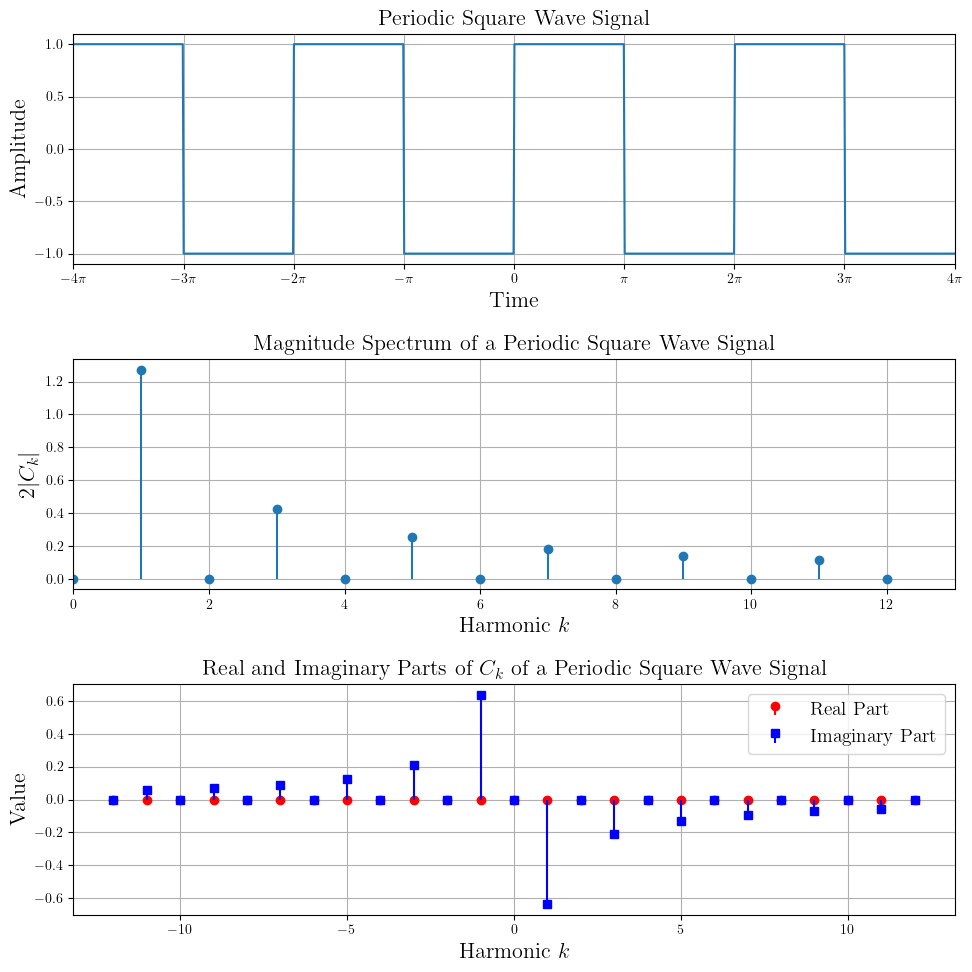

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def square_wave(t, T=2*np.pi, A=1):
    """ Generate a square wave signal. """
    return A*np.sign(np.sin(2 * np.pi * t / T))

def fourier_series_coefficients_square_wave(N, T=2*np.pi, A=1):
    """ Compute Fourier series coefficients for a square wave. """
    C_k = np.zeros(2 * N + 1, dtype=complex)
    k_values = np.arange(-N, N + 1)

    for k in k_values:
        if np.mod(k, 2) > 0:
            if k > 0:
                # Fourier coefficients (only odd harmonics have non-zero coefficients)
                C_k[k + N] = (2j*A/np.pi) * (-np.sign(k)/k)
            else:
                C_k[k + N] = np.conjugate((2j*A/np.pi) * (-np.sign(k)/k))

    return k_values, C_k

# Parameters
T = 2 * np.pi  # Period of the square wave
N = 12  # Number of harmonics (will plot from -N to +N)
A = 1  # Amplitude of the square wave

# Periodic square wave
t = np.linspace(-2*T, 2*T, 1000)
square_wave_signal = square_wave(t, T, A)

# Generate the Fourier series coefficients
k_values, C_k = fourier_series_coefficients_square_wave(N, T, A)

# Magnitudes (D_k)
magnitudes = 2*np.abs(C_k)

# Real and Imaginary Parts
real_parts = np.real(C_k)
imaginary_parts = np.imag(C_k)

# Plotting the frequency domain plots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot 1: Square Wave Signal
axs[0].plot(t, square_wave_signal)
axs[0].set_title('Periodic Square Wave Signal')
axs[0].set_xlabel('Time')
axs[0].set_xticks(np.linspace(-2*T, 2*T, 9))
axs[0].set_xlim([-2*T, 2*T])
axs[0].set_xticklabels(['$-4\pi$', '$-3\pi$', '$-2\pi$', '$-\pi$', '$0$', '$\pi$', '$2\pi$', '$3\pi$', '$4\pi$'])
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# Plot 2: Magnitude Spectrum
axs[1].stem(k_values[N:2*N+1], magnitudes[N:2*N+1], basefmt=" ")
axs[1].set_title('Magnitude Spectrum of a Periodic Square Wave Signal')
axs[1].set_xlabel('Harmonic $k$')
axs[1].set_ylabel('$2|C_k|$')
axs[1].set_xlim([0,N+1])
axs[1].grid(True)

# Plot 3: Real and Imaginary Parts of C_k
axs[2].stem(k_values, real_parts, linefmt='r-', markerfmt='ro', basefmt=" ", label='Real Part')
axs[2].stem(k_values, imaginary_parts, linefmt='b-', markerfmt='bs', basefmt=" ", label='Imaginary Part')
axs[2].set_title('Real and Imaginary Parts of $C_k$ of a Periodic Square Wave Signal')
axs[2].set_xlabel('Harmonic $k$')
axs[2].set_ylabel('Value')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()


## **Fourier Transform Example**

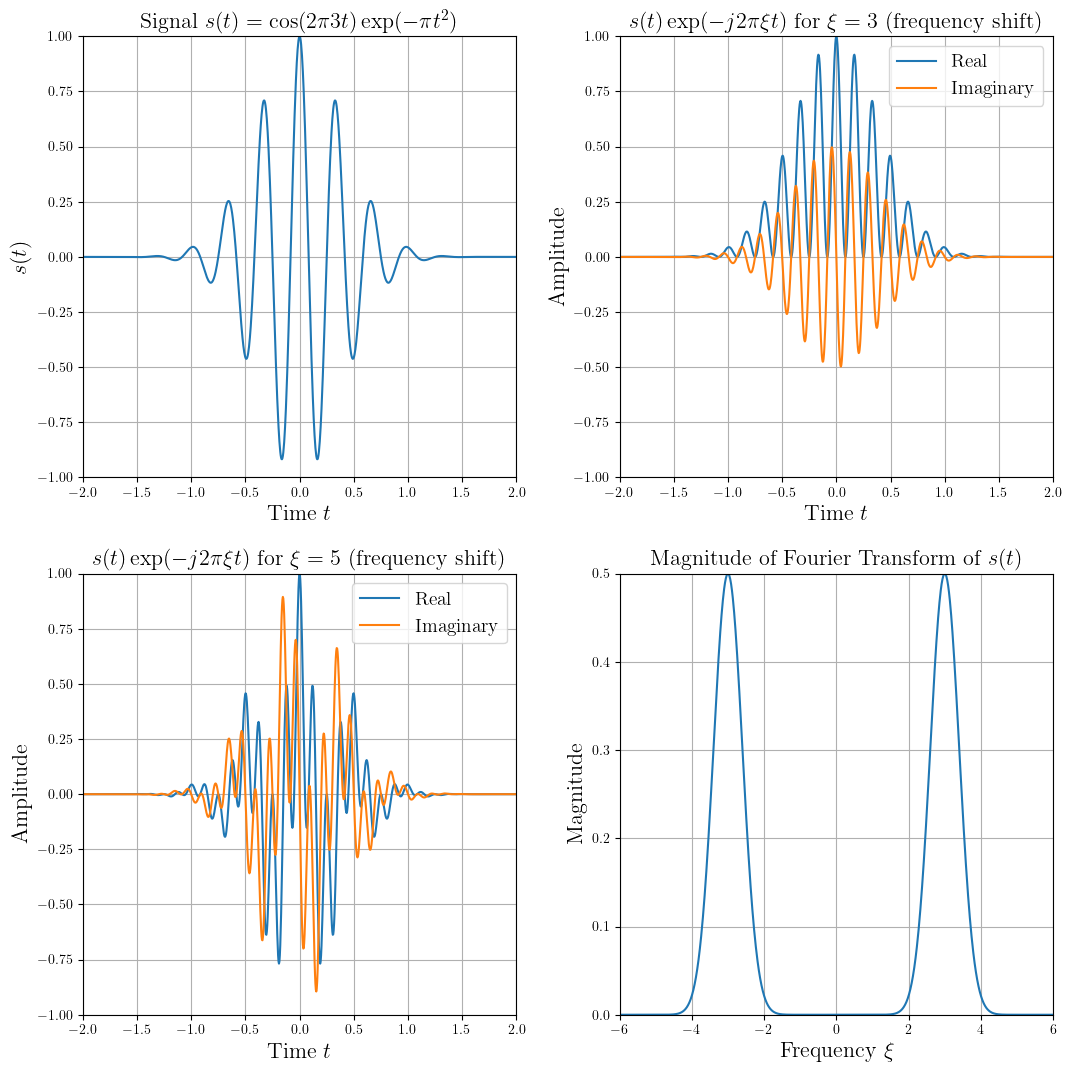

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define the signal s(t) = cos(2*pi*3*t) * exp(-pi*t^2)
def s(t):
    return np.cos(2 * np.pi * 3 * t) * np.exp(-np.pi * t**2)

# Define the multiplication with exp(-j*2*pi*xi*t) (shifting factor for Fourier transform)
def multiplied_signal(t, xi):
    return s(t) * np.exp(-2j * np.pi * xi * t)

# Fourier transform (integral of the multiplication)
def fourier_transform(t, xi):
    # We integrate over a sufficiently large range
    integrand = s(t) * np.exp(-2j * np.pi * xi * t)
    return np.trapz(integrand, t)  # Trapezoidal rule for numerical integration

# Define the time domain
time_max = 2
frequency_max = 6
t = np.linspace(-time_max, time_max, 1000)
f = np.linspace(-frequency_max, frequency_max, 1000)

fig = plt.figure(figsize=(11, 11))
gs = GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# Plot the original signal s(t)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t, s(t))
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('$s(t)$')
ax1.set_title('Signal $s(t) = \cos(2\pi3t)\exp(-\pi t^2)$')
ax1.set_xlim([-time_max,time_max])
ax1.set_ylim(-1,1)
ax1.grid(True)
#ax1.axis('equal')

# Plot the real and imaginary parts of the multiplication for f=3
f1 = 3
mult_signal_f1 = multiplied_signal(t, f1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t, np.real(mult_signal_f1), label='Real')
ax2.set_xlim([-time_max,time_max])
ax2.set_ylim(-1,1)
ax2.plot(t, np.imag(mult_signal_f1), label='Imaginary')
ax2.set_title(r'$s(t)\exp(-j2\pi \xi t)$ for $\xi=3$ (frequency shift)')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel('Amplitude')
ax2.legend()
ax2.grid(True)

# Plot the real and imaginary parts of the multiplication for f=5
f2 = 5
mult_signal_f2 = multiplied_signal(t, f2)
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(t, np.real(mult_signal_f2), label='Real')
ax3.plot(t, np.imag(mult_signal_f2), label='Imaginary')
ax3.set_title(r'$s(t)\exp(-j2\pi \xi t)$ for $\xi=5$ (frequency shift)')
ax3.set_xlabel('Time $t$')
ax3.set_ylabel('Amplitude')
ax3.set_xlim([-time_max,time_max])
ax3.set_ylim(-1,1)
ax3.legend()
ax3.grid(True)

# Plot the Fourier transform as a function of frequency f
fourier_values = np.array([fourier_transform(t, ff) for ff in f])

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(f, np.abs(fourier_values), label='Fourier Transform (Magnitude)')
ax4.set_xlim([-frequency_max,frequency_max])
ax4.set_ylim([0,0.5])
ax4.set_title('Magnitude of Fourier Transform of $s(t)$')
ax4.set_xlabel(r'Frequency $\xi$')
ax4.set_ylabel('Magnitude')
ax4.grid(True)

plt.tight_layout()
plt.show()


## **2D Discrete Fourier Transform (DFT)**

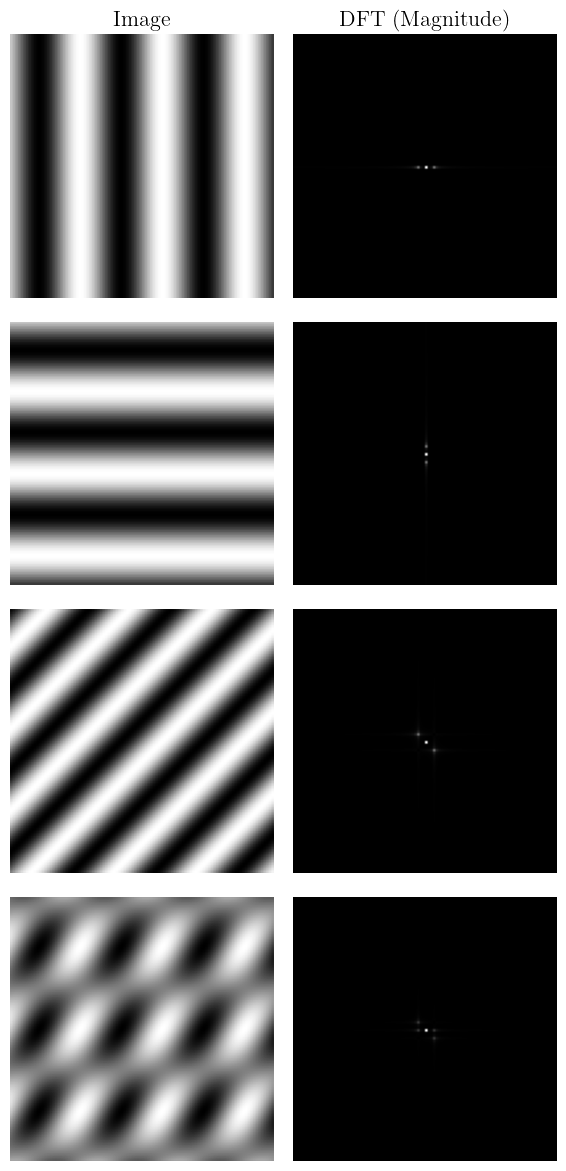

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def discret_fourier_transform_2D(image):
    # Compute the 2D Fourier Transform
    F = np.fft.fft2(image)

    return np.fft.fftshift(F)  # Shift the zero frequency component to the center

# Create meshgrid for 2D images
xx = np.linspace(-10, 10, 100)
yy = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(xx, yy)

# Plot the original image and its Fourier Transform
plt.figure(figsize=(6, 12))

# Horizontal image
image = (np.sin(xx)+1)/2  # the scaling is to push the [-1,1] values to [0,1]
DFT = np.abs(discret_fourier_transform_2D(image))  # Compute the magnitude spectrum for visaulization
# Plot the original image
plt.subplot(4, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.axis('off')
# Plot the Fourier Transform magnitude spectrum
plt.subplot(4, 2, 2)
plt.imshow(DFT, cmap='gray')
plt.title('DFT (Magnitude)')
plt.axis('off')

# Vertical image
image = (np.sin(yy)+1)/2
DFT = np.abs(discret_fourier_transform_2D(image))
# Plot the original image
plt.subplot(4, 2, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
# Plot the Fourier Transform magnitude spectrum
plt.subplot(4, 2, 4)
plt.imshow(DFT, cmap='gray')
plt.axis('off')

# Diagonal image
image = (np.sin(xx+yy)+1)/2
DFT = np.abs(discret_fourier_transform_2D(image))
# Plot the original image
plt.subplot(4, 2, 5)
plt.imshow(image, cmap='gray')
plt.axis('off')
# Plot the Fourier Transform magnitude spectrum
plt.subplot(4, 2, 6)
plt.imshow(DFT, cmap='gray')
plt.axis('off')

# Horizontal+Diagonal image
image = (np.sin(xx)+1)/2+(np.sin(xx+yy)+1)/2
DFT = np.abs(discret_fourier_transform_2D(image))
# Plot the original image
plt.subplot(4, 2, 7)
plt.imshow(image, cmap='gray')
plt.axis('off')
# Plot the Fourier Transform magnitude spectrum
plt.subplot(4, 2, 8)
plt.imshow(DFT, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## **DFT and IDFT**

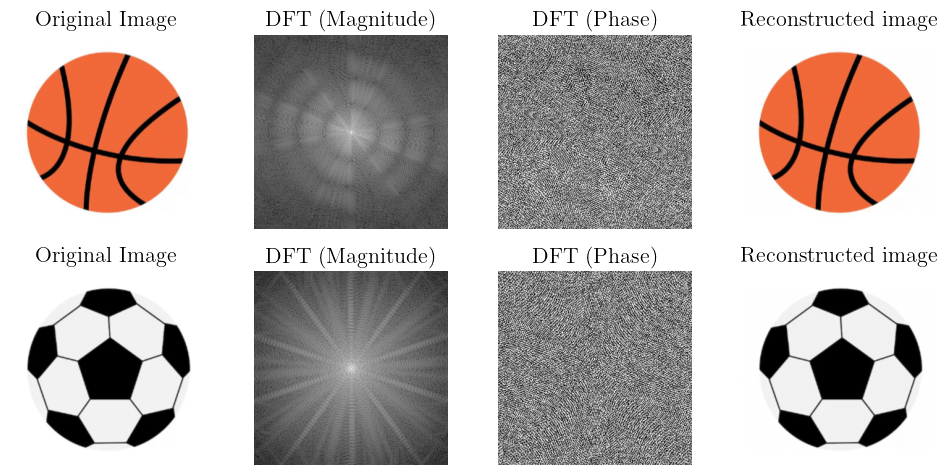

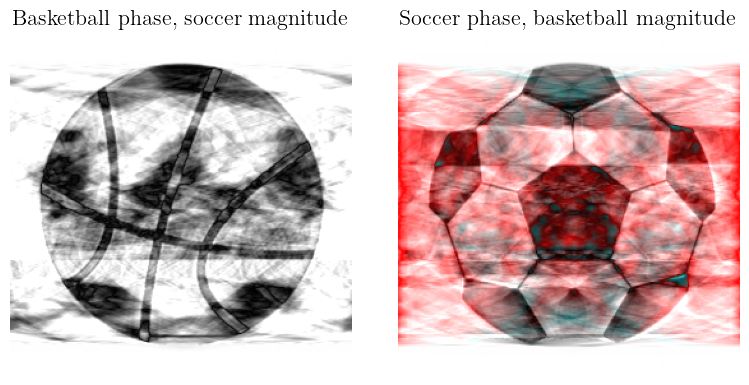

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def discret_fourier_transform_2D(image):
    # Compute the 2D Fourier Transform
    F = np.fft.fft2(image)
    return np.fft.fftshift(F)  # Shift the zero frequency component to the center

def reconstruct_image(phase_source, magnitude_source):
    """Reconstruct an image using the phase from one source and magnitude from another."""
    combined = magnitude_source * np.exp(1j * np.angle(phase_source))  # it is easy to show that taking the magnitude of one DFT with the phases of the other, then thi smultiplication gives a complex number with a combined magnitude and phase
    reconstructed = np.fft.ifft2(np.fft.ifftshift(combined))  # we apply ifftshift because we first needs to set the zero frequency back to the forst location, so the ifft2 will be applied on the form it expects
    return np.abs(reconstructed)

# Load two images
image1 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_basket.png', 1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)/255.0
image2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 1)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)/255.0
# Notice that for color images, the FFT is applies to each channel separately

image1_gray = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_basket.png', 0)
image2_gray = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 0)
# For plotting purposes of magnitude and phase

# Ensure the images are the same size
image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
image2_gray = cv2.resize(image2_gray, (image1_gray.shape[1], image1_gray.shape[0]))

# Apply DFT
image1DFT = discret_fourier_transform_2D(image1)
image2DFT = discret_fourier_transform_2D(image2)
image1_grayDFT = discret_fourier_transform_2D(image1_gray)
image2_grayDFT = discret_fourier_transform_2D(image2_gray)

# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(2, 4, 1)
plt.imshow(image1)
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 4, 2)
plt.imshow(np.log10(np.abs(image1_grayDFT)),cmap='gray')
plt.title('DFT (Magnitude)')
plt.axis('off')
plt.subplot(2, 4, 3)
plt.imshow(np.angle(image1_grayDFT), cmap='gray')
plt.title('DFT (Phase)')
plt.axis('off')
plt.subplot(2, 4, 4)
plt.imshow(reconstruct_image(image1DFT, np.abs(image1DFT)))
plt.title('Reconstructed image')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(image2)
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 4, 6)
plt.imshow(np.log10(np.abs(image2_grayDFT)),cmap='gray')
plt.title('DFT (Magnitude)')
plt.axis('off')
plt.subplot(2, 4, 7)
plt.imshow(np.angle(image2_grayDFT), cmap='gray')
plt.title('DFT (Phase)')
plt.axis('off')
plt.subplot(2, 4, 8)
plt.imshow(reconstruct_image(image2DFT, np.abs(image2DFT)))
plt.title('Reconstructed image')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(reconstruct_image(image1DFT, np.abs(image2DFT)))
plt.title('Basketball phase, soccer magnitude')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstruct_image(image2DFT, np.abs(image1DFT)))
plt.title('Soccer phase, basketball magnitude')
plt.axis('off')
plt.tight_layout()
plt.show()



## **Frequency-Domain Filtering**

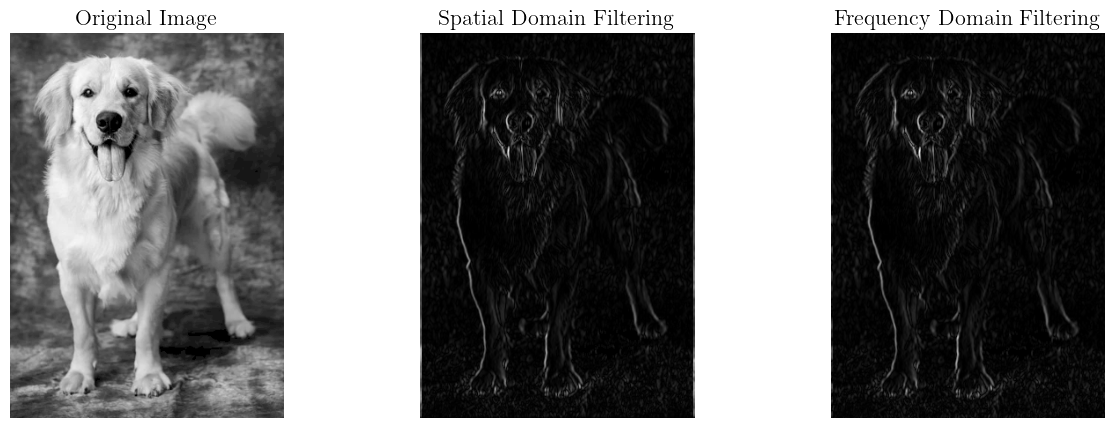

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def pad_filter_to_image(filter, image_shape):
    """Pad the filter to match the image shape (zero-padding)."""
    padded_filter = np.zeros(image_shape)
    f_rows, f_cols = filter.shape
    padded_filter[image_shape[0]//2:image_shape[0]//2+f_rows, image_shape[1]//2:image_shape[1]//2+f_cols] = filter  # place the filter at the center of the padded filter
    return padded_filter

def spatial_filtering(image, filter):
    """Convolves the image with the filter in the spatial domain."""
    return convolve2d(image, filter)

def frequency_domain_filtering(image, filter):
    """Convolves the image with the filter in the frequency domain."""
    # Pad the filter to the image's size
    padded_filter = pad_filter_to_image(filter, image.shape)

    # Perform FFT on the image and the padded filter
    fft_image = np.fft.fftshift(np.fft.fft2(image))
    fft_filter = np.fft.fftshift(np.fft.fft2(padded_filter))

    # Multiply in the frequency domain (element-wise)
    fft_result = fft_image * fft_filter

    # Inverse FFT to get back to spatial domain
    convolved_image = np.fft.ifftshift(np.fft.ifft2(fft_result))

    return convolved_image, fft_filter

def plot_results(image, spatial_result, frequency_result):
    """Plot the original image and the two convolution results."""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(spatial_result, cmap='gray')
    plt.title('Spatial Domain Filtering')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(frequency_result, cmap='gray')
    plt.title('Frequency Domain Filtering')
    plt.axis('off')

    plt.show()

image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/dog.PNG', 0)
filter = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])  # Edge detection filter

# Perform spatial domain convolution
spatial_result = spatial_filtering(image, filter)

# Perform frequency domain convolution
frequency_result, _ = frequency_domain_filtering(image, filter)

# Plot the magnitued and compare the results
plot_results(image, np.abs(spatial_result), np.abs(frequency_result))


## **Gaussian and Box Blur Filtering in Frequency-Domain**

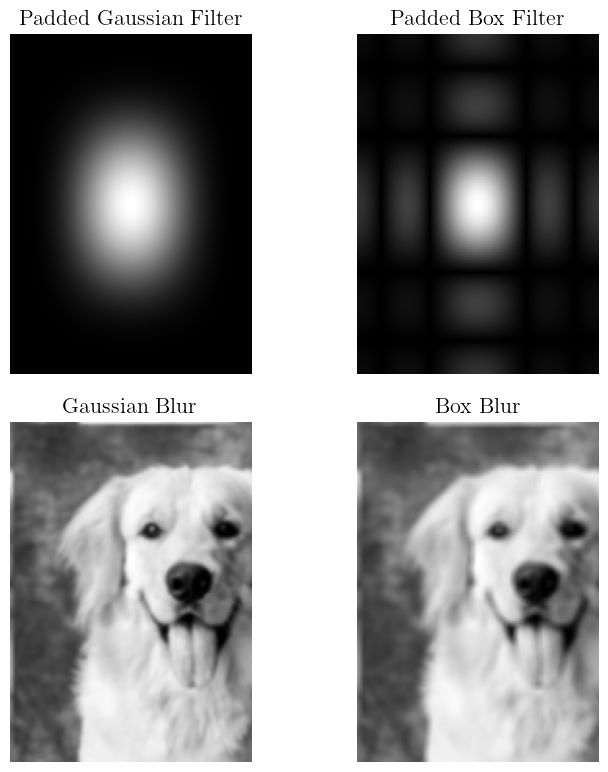

In [14]:
import numpy as np
import matplotlib.pyplot as plt


def plot_filters_and_results(image, gaussian_filter, box_filter, filtered_gaussian, filtered_box):
    """Plot the padded filters and the filtered images."""
    plt.figure(figsize=(8, 8))

    # Display the padded Gaussian filter
    plt.subplot(2, 2, 1)
    plt.imshow(gaussian_filter, cmap='gray')
    plt.title('Padded Gaussian Filter')
    plt.axis('off')

    # Display the padded Box filter
    plt.subplot(2, 2, 2)
    plt.imshow(box_filter, cmap='gray')
    plt.title('Padded Box Filter')
    plt.axis('off')

    # Display the result of the Gaussian filter
    plt.subplot(2, 2, 3)
    plt.imshow(filtered_gaussian, cmap='gray')
    plt.title('Gaussian Blur')
    plt.axis('off')

    # Display the result of the Box filter
    plt.subplot(2, 2, 4)
    plt.imshow(filtered_box, cmap='gray')
    plt.title('Box Blur')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example image
image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/dog.PNG', 0)
image = image[:image.shape[0]//2, :image.shape[1]//2]

# Define a 5x5 Gaussian blur filter
gaussian_blur = np.array([[1, 4, 6, 4, 1],
                          [4, 16, 24, 16, 4],
                          [6, 24, 36, 24, 6],
                          [4, 16, 24, 16, 4],
                          [1, 4, 6, 4, 1]]) / 256

# Define a 5x5 Box blur filter
box_blur = np.ones((5, 5)) / 25

# Pad the filters to the size of the image

# Perform frequency domain filtering
filtered_gaussian, gaussian_filter = frequency_domain_filtering(image, gaussian_blur)
filtered_box, box_filter = frequency_domain_filtering(image, box_blur)

# Plot the results
plot_filters_and_results(image, np.abs(gaussian_filter), np.abs(box_filter), np.abs(filtered_gaussian), np.abs(filtered_box))

## **Human Contrast Sensitivity Function**

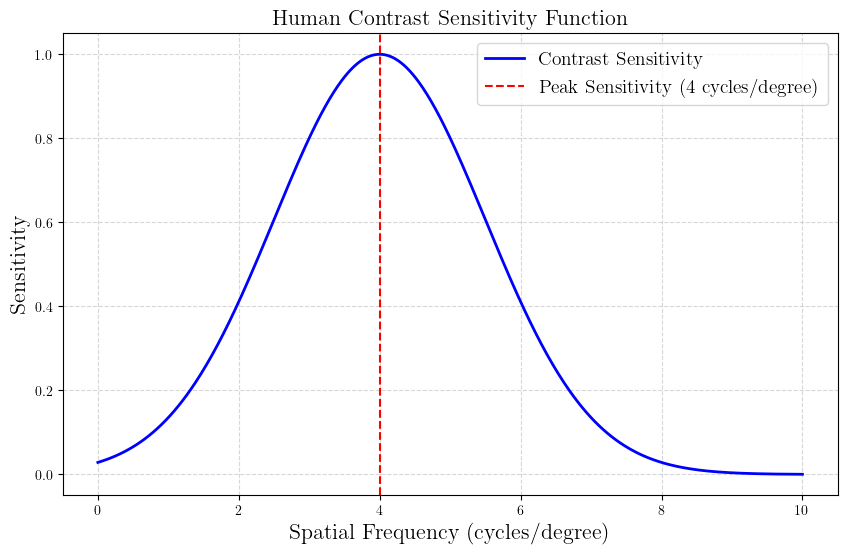

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def contrast_sensitivity_function(frequencies, peak_sensitivity=1.0, center_frequency=4.0, spread=1.0):
    """
    A simplified model of the human contrast sensitivity function (CSF).

    Parameters:
        frequencies (array): An array of spatial frequencies to evaluate.
        peak_sensitivity (float): The peak sensitivity (amplitude) of the function.
        center_frequency (float): The frequency at which the sensitivity is highest.
        spread (float): Determines how sharply the sensitivity drops off around the center frequency.

    Returns:
        An array representing the sensitivity at each frequency.
    """
    # Gaussian-shaped sensitivity function centered around the center frequency
    sensitivity = peak_sensitivity * np.exp(-((frequencies - center_frequency) ** 2) / (2 * spread ** 2))
    return sensitivity

# Generate an array of spatial frequencies ranging from 0 to 10 cycles per degree
frequencies = np.linspace(0, 10, 500)

# Calculate the contrast sensitivity values using the model
contrast_sensitivity = contrast_sensitivity_function(frequencies, peak_sensitivity=1.0, center_frequency=4.0, spread=1.5)

# Plot the contrast sensitivity function
plt.figure(figsize=(10, 6))
plt.plot(frequencies, contrast_sensitivity, label='Contrast Sensitivity', color='b', linewidth=2)
plt.axvline(x=4.0, color='r', linestyle='--', label='Peak Sensitivity (4 cycles/degree)')
plt.title('Human Contrast Sensitivity Function')
plt.xlabel('Spatial Frequency (cycles/degree)')
plt.ylabel('Sensitivity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

## **Mid-Range Frequency Image Blending**

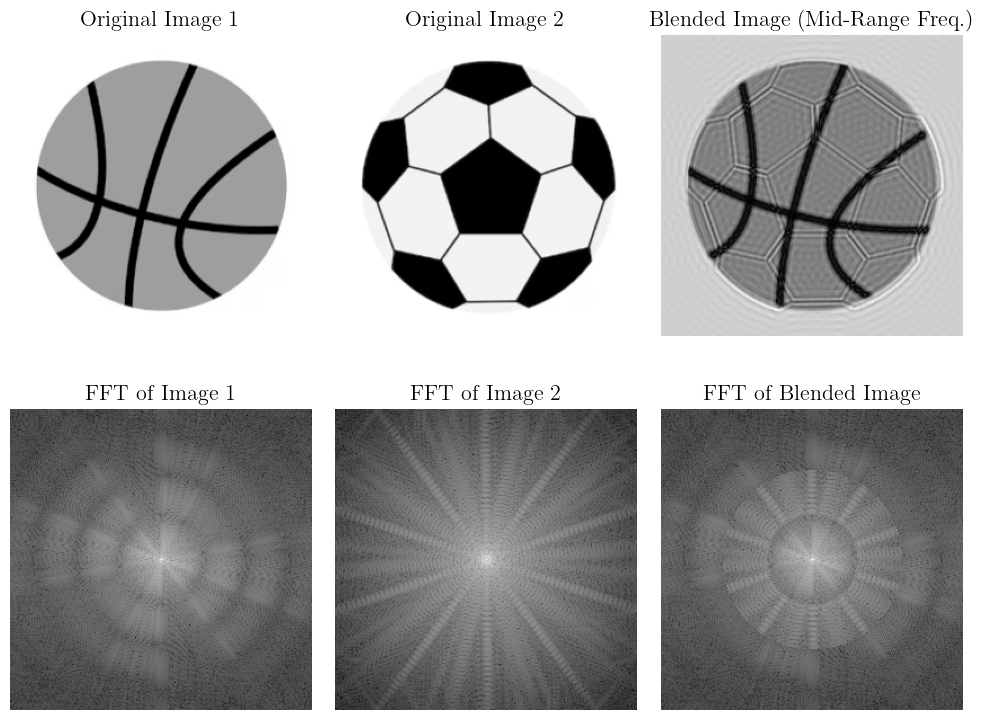

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def blend_mid_range_frequencies(image1, image2, low_cut=20, high_cut=60):
    """
    Blend two images by replacing the mid-range frequencies of image1 with those from image2.

    Parameters:
        image1: The base image (will have its mid-range frequencies replaced)
        image2: The source image for mid-range frequencies
        low_cut: The low frequency cutoff for the mid-range band
        high_cut: The high frequency cutoff for the mid-range band

    Returns:
        blended_image: The resulting image after blending mid-range frequencies
    """
    # Apply Fourier transform to both images
    fft_image1 = np.fft.fftshift(np.fft.fft2(image1))
    #plt.imshow(np.log10(np.abs(fft_image1)),cmap='gray')
    #plt.show()
    fft_image2 = np.fft.fftshift(np.fft.fft2(image2))
    #plt.imshow(np.log10(np.abs(fft_image2)),cmap='gray')
    #plt.show()
    #print(fft_image1, fft_image2)

    # Create a mask to isolate mid-range frequencies
    rows, cols = image1.shape
    crow, ccol = rows // 2, cols // 2  # Center of the frequency domain

    # Initialize masks
    fft_blended = np.copy(fft_image1)
    mask = np.zeros((rows, cols), dtype=np.int8)

    # Define a circular band for mid-range frequencies
    for x in range(rows):
        for y in range(cols):
            distance = np.sqrt((x - crow)**2 + (y - ccol)**2)
            if low_cut < distance < high_cut:
                fft_blended[x, y] = fft_image2[x, y]

    blended_image = np.abs(np.fft.ifft2(fft_blended))

    return blended_image, fft_blended, fft_image2, fft_image1


# Create two random images for demonstration
image1 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_basket.png', 0)/255.0
image2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ball_soccer.png', 0)[:image1.shape[0],:image1.shape[1]]/255.0

# Blend the images by replacing mid-range frequencies
blended_image, fft_blended, fft_image2, fft_image1 = blend_mid_range_frequencies(image1, image2, low_cut=40, high_cut=80)

# Plot the original and blended images
"""Plot the original images and the blended image."""
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1)
plt.imshow(image1, cmap='gray')
plt.title('Original Image 1')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image2, cmap='gray')
plt.title('Original Image 2')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(blended_image, cmap='gray')
plt.title('Blended Image (Mid-Range Freq.)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.log10(np.abs(fft_image1)), cmap='gray')
plt.title('FFT of Image 1')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.log10(np.abs(fft_image2)), cmap='gray')
plt.title('FFT of Image 2')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.log10(np.abs(fft_blended)), cmap='gray')
plt.title('FFT of Blended Image')
plt.axis('off')

plt.tight_layout()
plt.show()